In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Periodic Signals & The Lomb-Scargle Periodogram
By AA Miller (2019 Jun ~10)  
Updated by G Hosseinzadeh (2025 May 27)

This notebook discusses the detection of periodic signals in noisy, irregular data (the standard for ground-based astronomical surveys). The discussion below is strongly influenced by "Understanding the Lomb-Scarge Periodogram" ([VanderPlas 2017](http://adsabs.harvard.edu/abs/2017arXiv170309824V)). Beyond that, the original papers by [Lomb (1976)](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle (1982)](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) are also worth a read. Though there are many, many papers on the use of the Lomb-Scargle periodogram, [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) conducted a systematic analysis of many of the most popular tools used to search for periodic signals on *actual astronomical data* and found that none of the solutions work really well across all use cases!

We'll be using a sinusoidal model throughout this exercise, so write a function that implements the following equation:

$$ y = A\,\sin\left(\frac{2{\pi}x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are free parameters. It should have the option to Gaussian noise, $\sigma_y$, for each output $y_i$.

Test that it works by generating a noise-free signal with $A = 2$ and $P = \pi$ over a regular grid between 0 and 10. Plot the results.

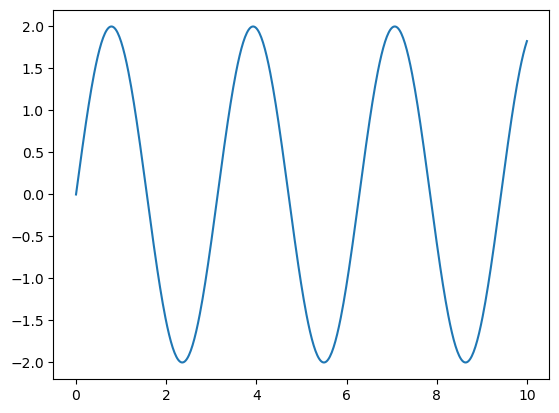

In [18]:
rng = np.random.default_rng()

def sinusoid(x, period=1, amplitude=1, phase=0, noise=0):
    return  amplitude * np.sin((2 * np.pi * x / period) - phase) + noise

x = np.linspace(0, 10, 500)
y = sinusoid(x, period=np.pi, amplitude=2, phase=0, noise=0)
plt.plot(x, y)

## Problem 1) The Lomb-Scargle Periodogram

**Problem 1a**

Write a function, `chi2`, to calculate the $\chi^2$ given $f$, $A_f$, and $\phi$, for observations $y_n$ with uncertainties $\sigma_{y,n}$ taken at times $t_n$.

*Hint* - it may be helpful to access $A_f$, and $\phi$ from a single variable `theta`, where `a = theta[0]` and `phi = theta[1]`

In [35]:
def chi2(theta, f, t, y, sigma):
    a = theta[0]
    phi = theta[1]
    model = a * np.sin(2 * np.pi * f * t - phi)
    return np.sum(((y - model) / sigma) ** 2)

**Problem 1b**

Write a function to minimize the $\chi^2$ given everything but $A_f$ and $\phi_f$.

*Hint* - you may find [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) within the `scipy` package useful.

In [36]:
from scipy.optimize import minimize

def min_chi2(f, t, y, sigma):
    # Initial guess
    theta0 = [1.0, 0.0]
    
    result = minimize(chi2, theta0, args=(f, t, y, sigma))
    return result.fun

**Problem 1c**

Write a function, `ls_periodogram`, to calculate the LS periodogram for observations $y$, $\sigma_y$, $t$ over a frequency grid `f_grid`.

In [37]:
def ls_periodogram(t, y, sigma, f_grid):
    psd = np.zeros_like(f_grid)
    chi2_0 = np.sum((y / sigma) ** 2)
    
    for f_num, f in enumerate(f_grid):
        chi2_f = min_chi2(f, t, y, sigma)
        psd[f_num] = 0.5 * (chi2_0 - chi2_f)
    return psd

**Problem 1d**

Generate a periodic signal with 100 observations taken over a time period of 10 days. Use an input period of 5.25, amplitude of 7.4, and variance of the noise = 0.8. To make this more realistic, randomly generate uncertainties from a half-Gaussian with a standard deviation of 0.8. Then compute and plot the periodogram for the simulated data. Do you recover the simulated period?

*Hint* - set the minimum frequency in the grid to $1/T$ where $T$ is the duration of the observations. Set the maximum frequnecy to 10, and use an equally spaced grid with 50 points. 

<ErrorbarContainer object of 3 artists>

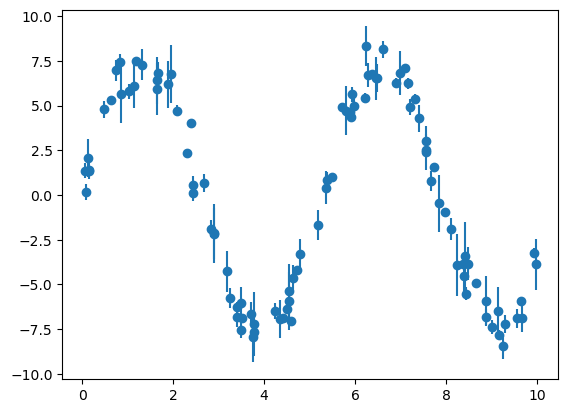

In [38]:
rng = np.random.default_rng()
x = np.sort(10 * rng.random(100))
y = 7.4 * np.sin(2 * np.pi * x / 5.25) + rng.normal(0, 0.8, size=x.size)
y_unc = np.abs(rng.normal(loc=0, scale=0.8, size=x.size))

plt.errorbar(x, y, yerr=y_unc, fmt='o')

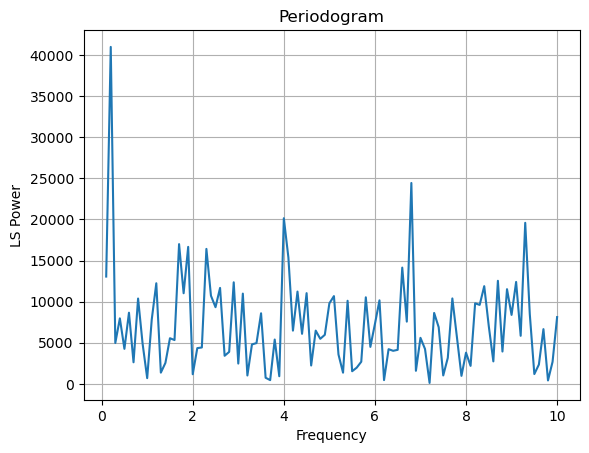

The best fit period is: 5.0000


In [46]:
# calculate the periodogram
f_min =  1 / 10
f_grid = np.linspace(f_min, 10, 100)
psd_ls = ls_periodogram(x, y, y_unc, f_grid)

# plot the periodogram
plt.plot(f_grid, psd_ls)
plt.xlabel("Frequency")
plt.ylabel("LS Power")
plt.title("Periodogram")
plt.grid(True)
plt.show()

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))

**Problem 1e**

For the same data, include 1000 points in `f_grid` and calculate and plot the periodogram. 

Now do you recover the correct period?

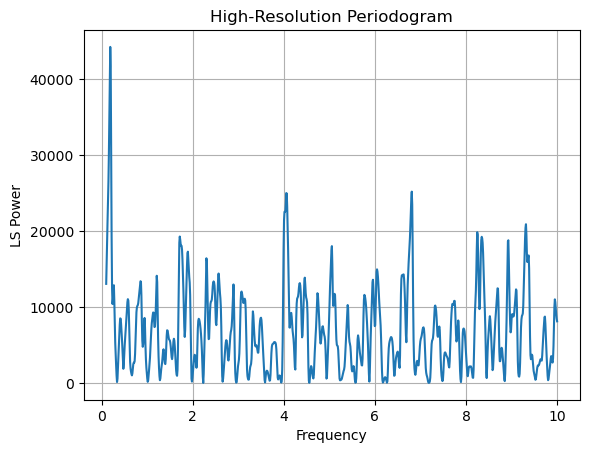

The best fit period is: 5.2857


In [47]:
# calculate the periodogram
f_min =  1 / 10
f_grid = np.linspace(f_min, 10, 1000)
psd_ls = ls_periodogram(x, y, y_unc, f_grid)

# plot the periodogram
plt.plot(f_grid, psd_ls)
plt.xlabel("Frequency")
plt.ylabel("LS Power")
plt.title("High-Resolution Periodogram")
plt.grid(True)
plt.show()

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))

**Problem 1f**

Plot the phase-folded data at the newly found "best" fit period.

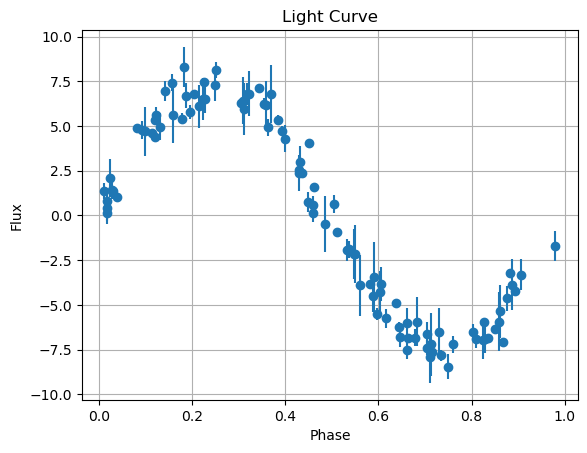

In [48]:
period = 1. / f_grid[np.argmax(psd_ls)]
phases = (x % period) /period
    
plt.plot()
plt.errorbar(phases, y, yerr=y_unc, fmt='o')
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.grid(True)
plt.show()

**Problem 1g**

`ls_periodogram` functions well, but the way we implemented it is slow. [`LombScargle`](http://docs.astropy.org/en/stable/timeseries/lombscargle.html) in `astropy.timeseries` is fast. Run it below to compare the results to `ls_periodogram`. There are many choices regarding the calculation of the periodogram, so [read the docs](http://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle).

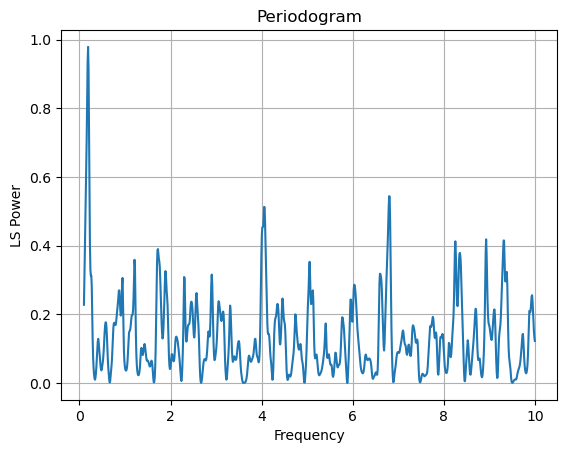

Best Period: 5.2416


In [53]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x, y, dy=y_unc).autopower(
    minimum_frequency=1/10,
    maximum_frequency=10,
    samples_per_peak=10
)
                               
# Plot 
plt.plot(frequency, power)
plt.xlabel("Frequency")
plt.ylabel("LS Power")
plt.title("Periodogram")
plt.grid(True)
plt.show()

print("Best Period: {:.4f}".format(1 / frequency[np.argmax(power)]))

## Problem 2: Floating Mean Periodogram

A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical applications, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`):

$$y(t;f) = y_0(f) + A_f \sin[2\pi f(t - \phi_f)].$$

To illustrate why this is important for astronomy, assume that any signal fainter than $-2$ in our simulated data cannot be detected. 

**Problem 2a**

Remove the observations from `x` and `y` where $y \le -2$ and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

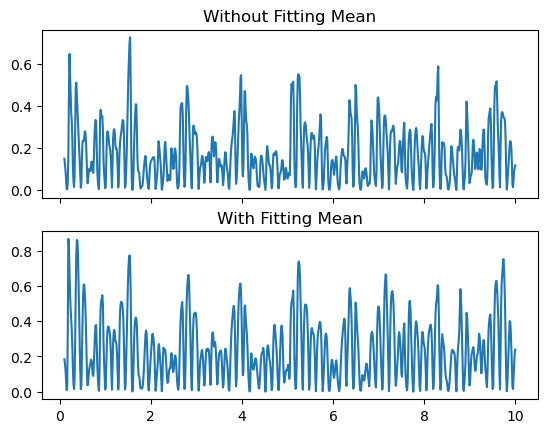

In [56]:
bright = y > -2

freq_no_mean, power_no_mean = LombScargle(x[bright], 
                                          y[bright], 
                                          dy=y_unc[bright], 
                                          fit_mean=False
                                         ).autopower(
    minimum_frequency=1/10, 
    maximum_frequency=10, 
    samples_per_peak=10)

freq_fit_mean, power_fit_mean = LombScargle(x[bright], 
                                            y[bright], 
                                            dy=y_unc[bright],
                                            fit_mean=True
                                           ).autopower(
    minimum_frequency=1/10, 
    maximum_frequency=10, 
    samples_per_peak=10)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(freq_no_mean, power_no_mean)
ax1.set_title("Without Fitting Mean")
ax2.plot(freq_fit_mean, power_fit_mean)
ax2.set_title("With Fitting Mean")

plt.show()

**Problem 2b**

Plot the reconstructed signals with and without the floating mean and compare them to the data.

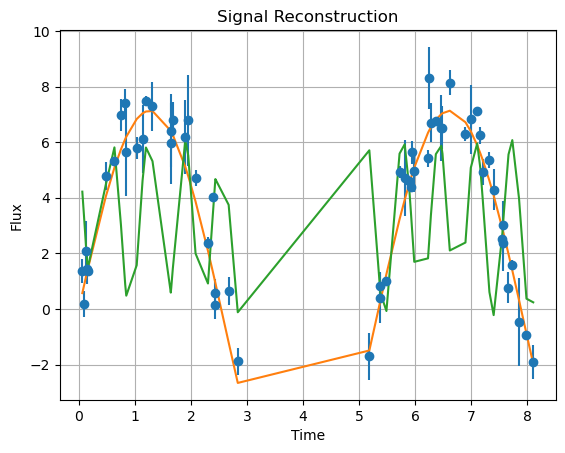

In [60]:
fit_mean_model = LombScargle(x[bright], 
                             y[bright], 
                             dy=y_unc[bright]
                            ).model(x[bright],
                                    freq_fit_mean[np.argmax(power_fit_mean)]) 
                                        
no_mean_model = LombScargle(x[bright], 
                             y[bright], 
                             dy=y_unc[bright],
                            fit_mean=False
                            ).model(x[bright],
                                    freq_no_mean[np.argmax(power_no_mean)]) 
                                        
# Plot
plt.errorbar(x[bright], y[bright], yerr=y_unc[bright], fmt='o')
plt.plot(x[bright], fit_mean_model)
plt.plot(x[bright], no_mean_model)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Signal Reconstruction")
plt.grid(True)
plt.show()

## Problem 3: Window Functions

Let us simulate "realistic" observations for a 10 year telescope survey. We do this by assuming that a source is observed every 3 nights (the LSST cadence) within $\pm 4\,\mathrm{hr}$ of the same time, and that $\sim 30\%$ of the observations did not occur due to bad weather. We further assume that the source cannot be observed for 40% of the year because it is behind the sun.

**Problem 3a**

Simulate a periodic signal with 3 day cadence (and the observing conditions described above), a period = 220 days (typical for Miras), amplitude = 12.4, and variance of the noise = 1. Randomly generate uncertainties from a half-Gaussian with a standard deviation of 1. Plot the simulated light curve.

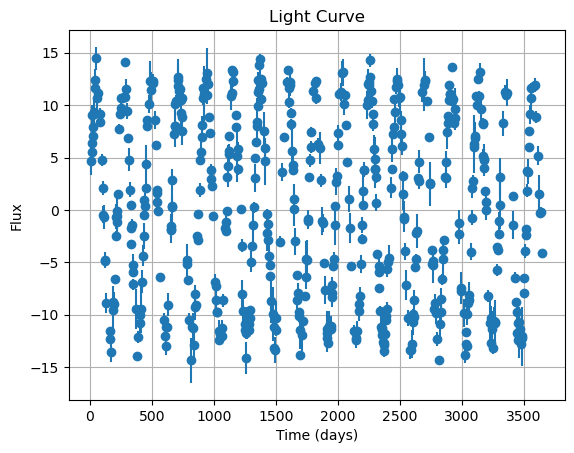

In [63]:
# set up simulated observations
rng = np.random.default_rng()

# 3day cadence
t_obs = np.arange(0, 3650, 3).astype(float)

# rand obs time
t_obs += rng.uniform(-4/24, 4/24, size=len(t_obs)) 

# behind the sun 40%
t_obs = t_obs[rng.random(len(t_obs)) > 0.4]

# bad weather 30%
t_obs = t_obs[rng.random(len(t_obs)) > 0.3]

# Simulate Light Curve
y = 12.4 * np.sin(2 * np.pi * t_obs / 220)

# Add noise
y += rng.normal(0, 1, size=len(y))

# Uncertainty
y_unc = np.abs(rng.normal(0, 1, size=len(y)))

# Plot
plt.errorbar(t_obs, y, yerr=y_unc, fmt='o')
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.grid(True)
plt.show()

**Problem 3b**

Calculate and plot the periodogram for the window function (i.e., set `y = 1` in `LombScargle`) of the observations. Do you notice any significant power? What are the periods for this power and what does this tell us?

*Hint* - you may need to zoom in on the plot to see all the relevant features.

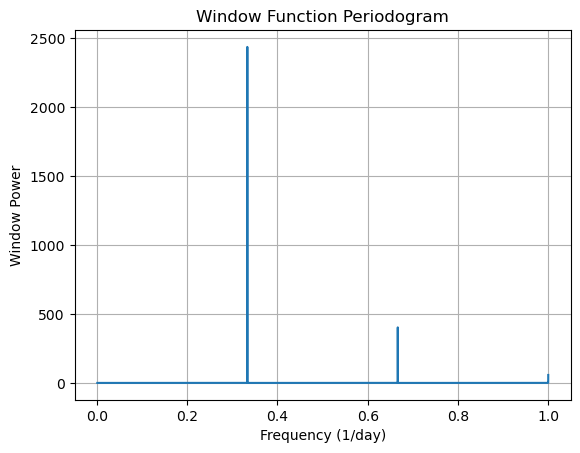

Strongest Widow Period: 3.00 days


In [65]:
ls = LombScargle(t_obs, np.ones_like(t_obs))

freq_window, power_window = ls.autopower(
    minimum_frequency=1/1000,
    maximum_frequency=1,
    samples_per_peak=10
)

# Plot 
plt.plot(freq_window, power_window)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Window Power")
plt.title("Window Function Periodogram")
plt.grid(True)
plt.show()

print(f"Strongest Widow Period: {1/freq_window[np.argmax(power_window)]:.2f} days")

*Complete*
Yes, the periodogram of the window function shows significant power at a period of 3 days which corespnds to the simulated observational candidates. The significant power at 3 days is a remindee that period detection must always account for the window function.

**Problem 3c**

Calculate the periodogram for the data and compare it to the periodogram for the window function. Do you notice any significant power? What are the periods for this power and what does this tell us?

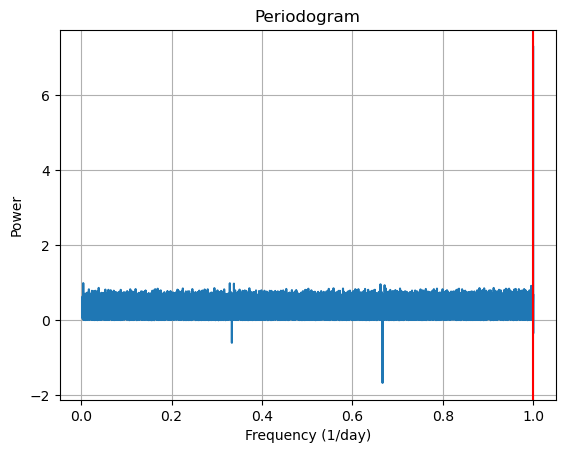

Strongest Period: 1.00 days


In [70]:
ls = LombScargle(t_obs, y, dy=y_unc)

frequency, power = ls.autopower(
    minimum_frequency=1/400,
    maximum_frequency=1,
    samples_per_peak=10
)

# Plot 
plt.plot(frequency, power)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Periodogram")

plt.axvline(frequency[np.argmax(power)], color='red')

plt.grid(True)
plt.show()


print(f"Strongest Period: {1/frequency[np.argmax(power)]:.2f} days")


*Complete*
yes, I do notice significant power specifically a strong peak near 1 day period. It does not match the actual one. This results ight highlights a problem caused by the window function which introduces artificial signals. It shows that regular gaps and observing cadence can create misleading periodicities.